In [185]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
import plotly.express as px
from utils import remove_leading_zeros, is_obsolete, forecastability, generate_lag
from tinyshift.series import fourier_seasonality
from tinyshift.plot import stationarity_check, seasonal_decompose, pami, residual_check, corr_heatmap
import pandas as pd
from statsforecast import StatsForecast
from utilsforecast.losses import rmse, mae, bias, cfe
from utilsforecast.evaluation import evaluate
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoTheta, AutoCES, AutoMFLES
import numpy as np
from tinyshift.modelling import filter_features_by_vif

In [186]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)

In [187]:
df.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

In [188]:
df

,ds,y,unique_id
0,1949-01-01,112,1
1,1949-02-01,118,1
2,1949-03-01,132,1
3,1949-04-01,129,1
4,1949-05-01,121,1
...,...,...,...
139,1960-08-01,606,1
140,1960-09-01,508,1
141,1960-10-01,461,1
142,1960-11-01,390,1


In [189]:
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")

In [190]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [191]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [192]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [193]:
obsolote_ids

[]

In [194]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [195]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [196]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [197]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
1          foreCA                                               0.571263
           theoretical_limit                                    0.086973
           stability_index                                      0.183962
           adi_cv                             (1.0, 0.18190737443351804)
           hurst_exponent       (0.5203628364992473, 0.8044229708616066)
Name: y, dtype: object

# ADF Test - Order of Diff 1

In [198]:
df["lag_1"] = generate_lag(df["y"], lag=1)
df["lag_12"] = generate_lag(df["lag_1"], lag=12)

In [199]:
df

,unique_id,ds,y,lag_1,lag_12
0,1,1949-01-01,112,NaN,NaN
1,1,1949-02-01,118,6.0,NaN
2,1,1949-03-01,132,14.0,NaN
3,1,1949-04-01,129,-3.0,NaN
4,1,1949-05-01,121,-8.0,NaN
...,...,...,...,...,...
139,1,1960-08-01,606,-16.0,-27.0
140,1,1960-09-01,508,-98.0,-2.0
141,1,1960-10-01,461,-47.0,9.0
142,1,1960-11-01,390,-71.0,-26.0


In [200]:
#df.groupby("unique_id")["lag_1"].apply(adfuller)

# Domingo

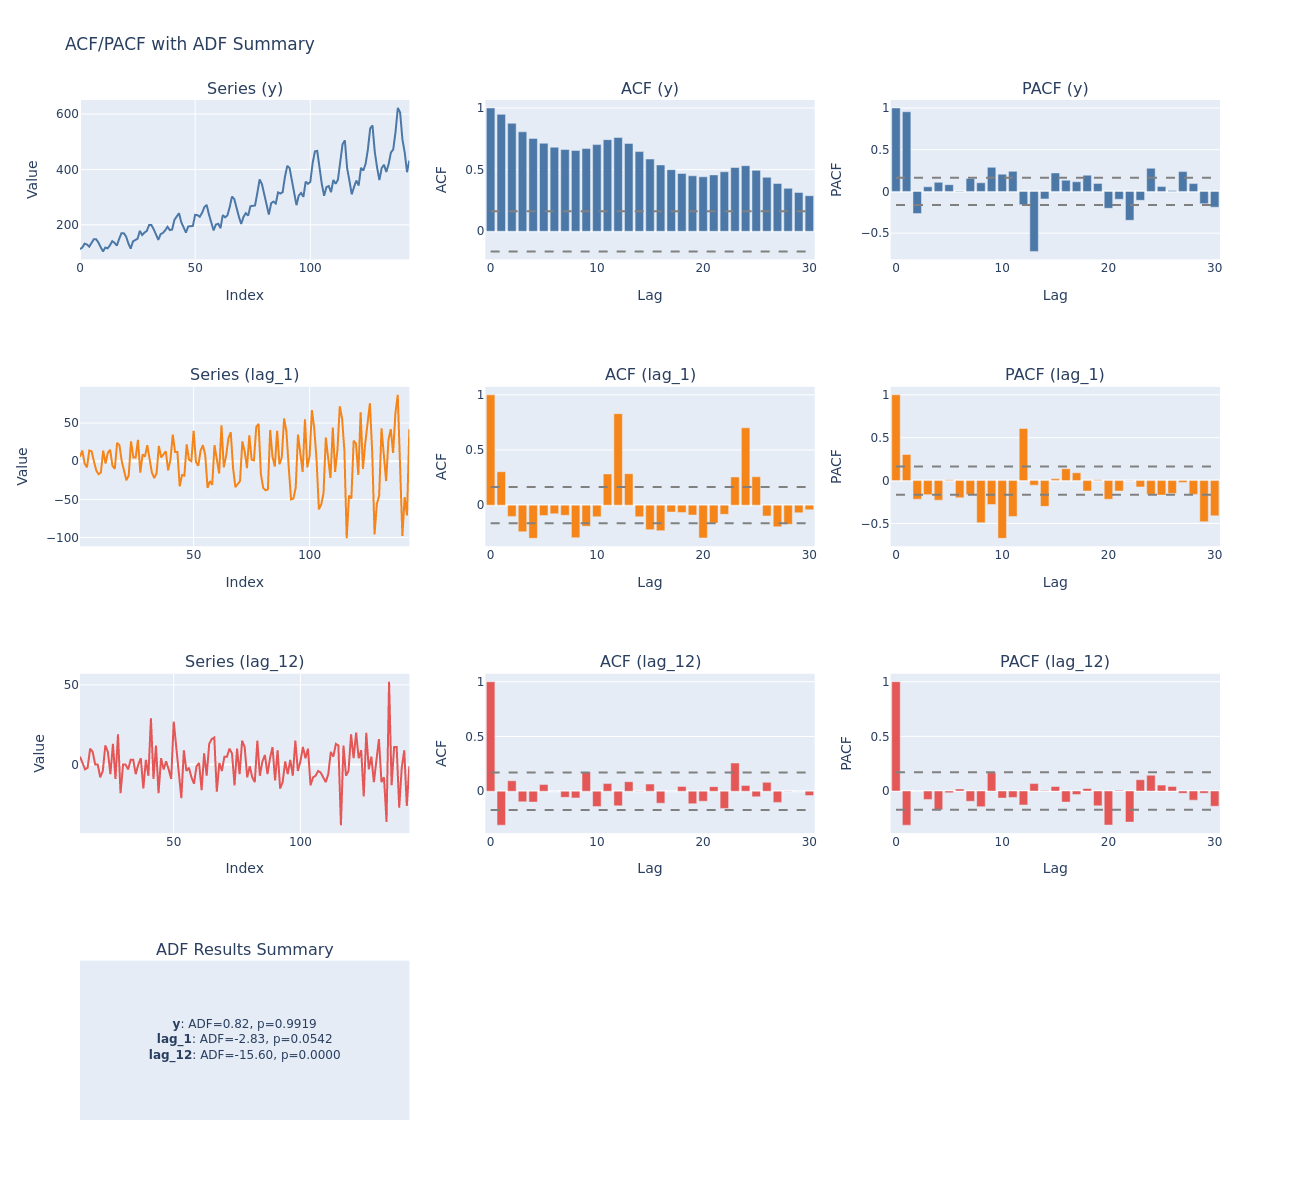

In [201]:
stationarity_check(df[["y", "lag_1", "lag_12"]], fig_type="png")

In [202]:
df.drop(columns=["lag_1", "lag_12"], inplace=True)

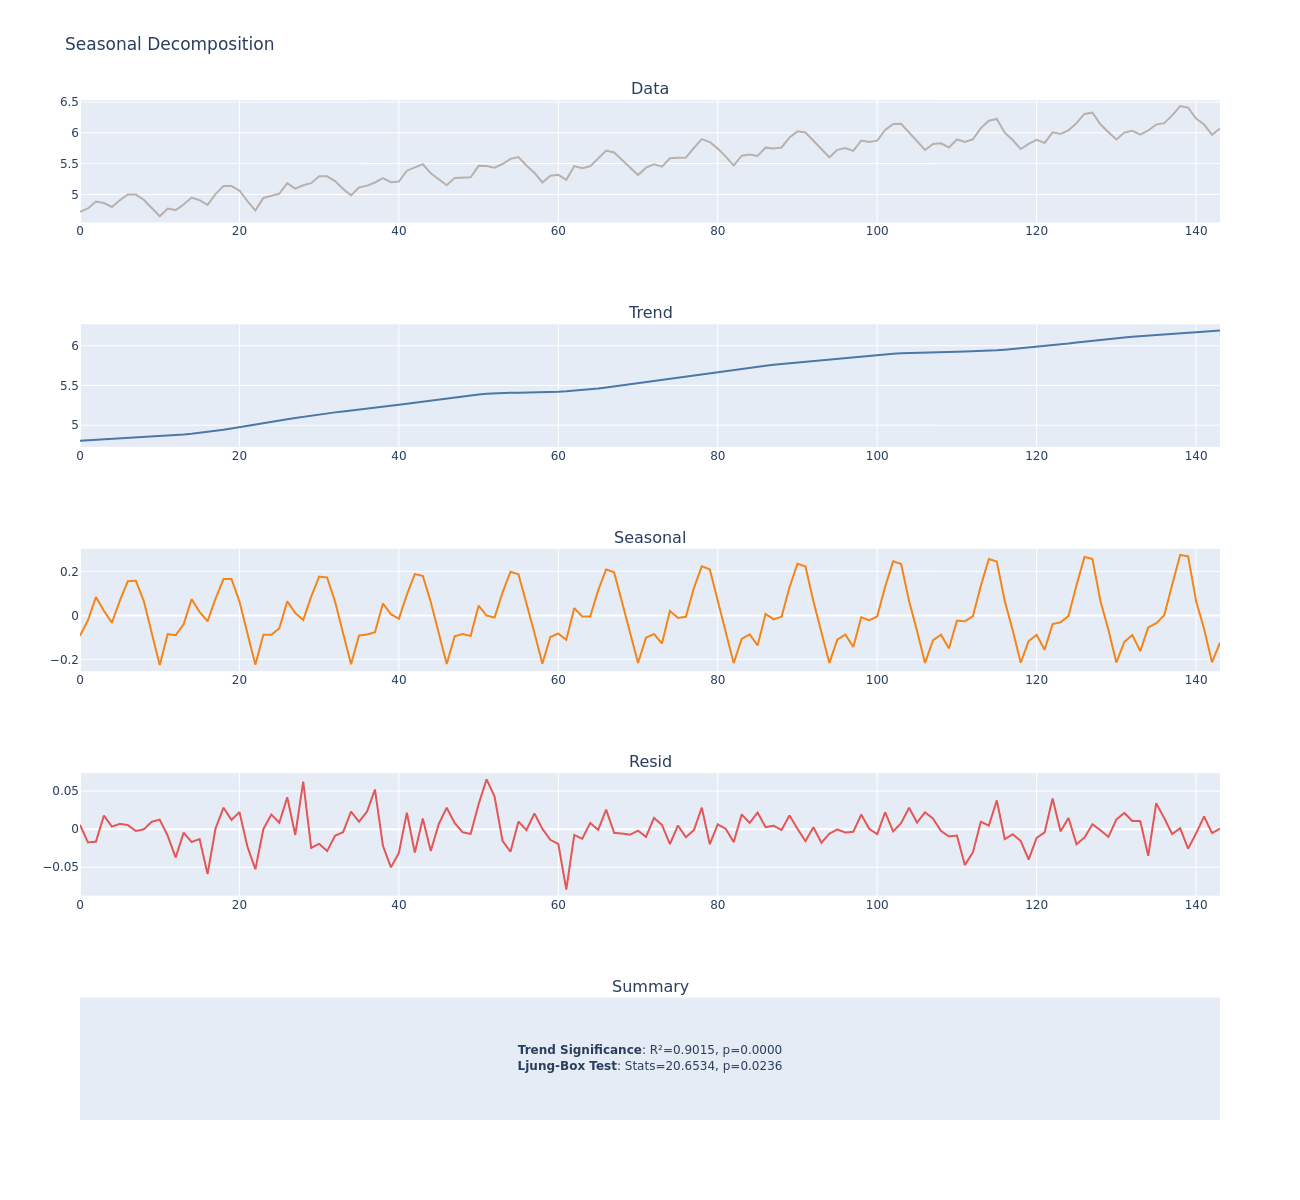

In [203]:
seasonal_decompose(np.log(df["y"]), periods=12, fig_type="png")

# PAMI

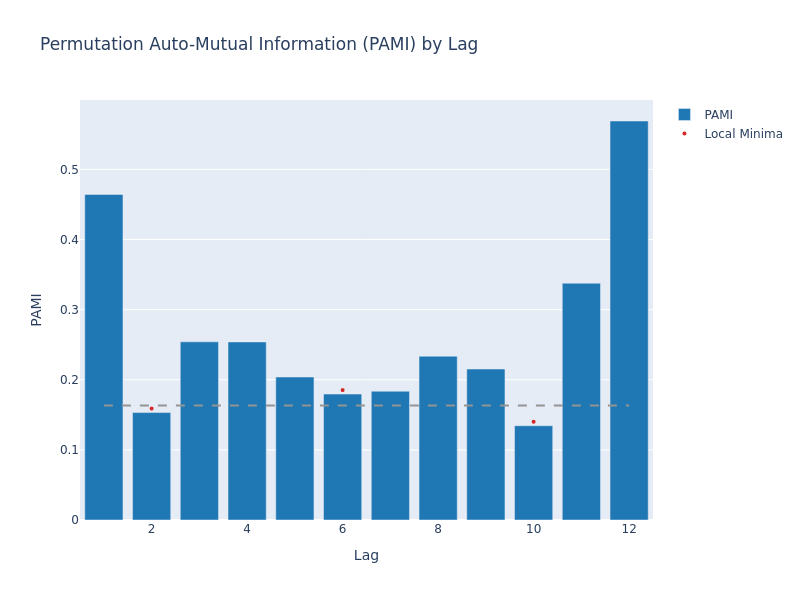

In [204]:
for id in df["unique_id"].unique():
    pami(df.loc[df["unique_id"] == id, "y"], nlags=12, m=3, delay=1, normalize=True, fig_type="png")

# Modelagem Estatística

In [205]:
seasonal_length = 12
sf = StatsForecast(
    models=[
        AutoARIMA(season_length=seasonal_length),
        AutoETS(season_length=seasonal_length),
        AutoTheta(season_length=seasonal_length),
        AutoCES(season_length=seasonal_length),
        AutoMFLES(season_length=seasonal_length, test_size=3, n_windows=5, metric = "mae"),
    ],
    freq='MS',
    fallback_model=Naive(),
    n_jobs=-1
)

In [206]:
horizon = 12
df = fourier_seasonality(df, "ds", seasonality=["monthly"])
#df["RANDOM_FEATURE_1"] = np.random.rand(len(df))
#df["RANDOM_FEATURE_2"] = np.random.normal(size=len(df))
train = df[:-horizon]
test = df[-horizon:]

In [207]:
def wape(actual, forecast):
    return np.sum(np.abs(actual - forecast)) / np.sum(np.abs(actual))

In [208]:
fc = sf.forecast(df=train[["unique_id", "ds", "y"]], h=horizon) #fit_predict

In [209]:
metrics = [
    mae,
    rmse,
    bias,
    cfe
]
models = ["AutoARIMA", "AutoETS", "AutoTheta", "CES", "SCUM", "AutoMFLES"]
scum = ["AutoARIMA", "AutoETS", "AutoTheta", "CES"]
fc["SCUM"] = fc[scum].median(axis=1)
fc.loc[fc["SCUM"] < 1e-1, "SCUM"] = 0

In [210]:
test = pd.merge(test, fc, on=["unique_id", "ds"], how="inner")
columns = ["unique_id", 
               "ds", 
               "y", 
               "AutoARIMA", 
               "AutoETS", 
               "AutoTheta", 
               "CES", 
               "SCUM", "AutoMFLES"]

In [211]:
wape(test["y"], test["AutoARIMA"])

np.float64(0.038885167982764375)

In [212]:
evaluate(test[columns], 
         metrics=metrics, 
         models=models, 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,AutoARIMA,AutoETS,AutoTheta,CES,SCUM,AutoMFLES
0,1,mae,18.515821,35.612475,19.357396,10.145073,12.008021,15.627861
1,1,rmse,23.919481,40.083621,24.985159,14.657908,16.899254,21.679438
2,1,bias,16.968961,-27.608716,-9.096141,5.823789,-2.396108,14.260185
3,1,cfe,203.627533,-331.304596,-109.153687,69.885468,-28.753296,171.122223


# Machine Learning (Linear Regression & Random Forest)

In [213]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, SeasonalRollingMean
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor

In [214]:
import numpy as np
from numba import njit

@njit
def hampel_filter(
    x: np.ndarray,
    window_size: int,
    factor: float = 3.0,
    scale: float = 1.4826,
) -> np.ndarray:
    """
    Identify outliers using a Numba-compiled implementation of the Hampel filter.

    The Hampel filter is a robust outlier detection method that uses the median and
    median absolute deviation (MAD) of a rolling window to identify points that
    deviate significantly from the local trend. This version is compiled with Numba
    for high-performance execution and compatibility with the Nixtla ecosystem.

    Parameters
    ----------
    x : ndarray of shape (n_samples,)
        Input 1D data to be filtered.
    window_size : int
        Size of the rolling window (must be odd and >= 3).
    factor : float, default=3.0
        Recommended values for common distributions (95% confidence):
        - Normal distribution: 3.0 (default)
        - Laplace distribution: 2.3
        - Cauchy distribution: 3.4
        - Exponential distribution: 3.6
        - Uniform distribution: 3.9
        Number of scaled MADs from the median to consider as outlier.
    scale : float, default=1.4826
        Scaling factor for MAD to make it consistent with standard deviation.
        Recommended values for different distributions:
        - Normal distribution: 1.4826 (default)
        - Uniform distribution: 1.16
        - Laplace distribution: 2.04
        - Exponential distribution: 2.08
        - Cauchy distribution: 1.0 (MAD is already consistent)

    Returns
    -------
    is_outlier : ndarray of shape (n_samples,)
        Boolean array indicating outliers (True) and inliers (False).

    Notes
    -----
    This function is JIT-compiled with Numba for optimal performance in the
    Nixtla ecosystem.
    """

    if window_size < 3 or window_size % 2 == 0:
        pass

    n = len(x)
    is_outlier = np.zeros(n, dtype=np.bool_)

    for i in range(n):
        start = max(0, i - window_size + 1)
        end = i + 1

        window = x[start:end]

        if len(window) < window_size:
            continue

        window_no_nan = window[~np.isnan(window)]

        if len(window_no_nan) < window_size:
            continue

        median = np.median(window_no_nan)
        mad = np.median(np.abs(window_no_nan - median))
        threshold = factor * mad * scale

        current_value = x[i]

        if np.isnan(current_value):
            continue

        if np.abs(current_value - median) > threshold:
            is_outlier[i] = True

    return is_outlier


In [215]:
def compute_lgbm_params(N: int):
    max_depth = int(np.ceil(np.log2(N) - 1))
    subsample_freq = 1
    colsample_bytree = 0.7
    n_estimators = 1000
    reg_lambda = 0.2
    reg_alpha = 0.2
    metric = "mae"
    learning_rate = 0.05
    min_child_samples = max(20, int(np.cbrt(N)))
    n_jobs = -1
    random_state = 42

    return {
        "max_depth": int(max_depth),
        "subsample_freq": subsample_freq,
        "colsample_bytree": colsample_bytree,
        "n_estimators": n_estimators,
        "metric": metric,
        "learning_rate": learning_rate,
        "num_leaves": 40,
        "min_child_samples": min_child_samples,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "objective": "regression_l2",
        "n_jobs": n_jobs,
        "random_state": random_state
    }

In [216]:
config = compute_lgbm_params(len(train))
models = [LinearRegression(), RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=int(np.ceil(np.log2(len(train)) - 1))), LGBMRegressor(**config, verbosity=-1)]

mf = MLForecast(
    models=models,
    freq='MS',
    lags=[2], #removi lag 1 e lag 12
    lag_transforms={
        1: [
        RollingMean(window_size=12), # Nível de longo prazo (12 meses)]},
        (hampel_filter, 3), # Detecta saltos em janela de 3 meses
        SeasonalRollingMean(window_size=2, season_length=12)
        ],
        6: [ExpandingMean()], # Média acumulada (longo prazo)
    },
    target_transforms=[Differences([1, 12])],
    date_features=["quarter"],
)

mf.fit(train, static_features=[])

MLForecast(models=[LinearRegression, RandomForestRegressor, LGBMRegressor], freq=MS, lag_features=['lag2', 'rolling_mean_lag1_window_size12', 'hampel_filter_lag1_window_size3', 'seasonal_rolling_mean_lag1_season_length12_window_size2', 'expanding_mean_lag6'], date_features=['quarter'], num_threads=1)

In [217]:
res = mf.predict(h=12, X_df=test[["unique_id", "ds", "monthly_sin", "monthly_cos"]])
res["y"] = test["y"]
evaluate(res, 
         metrics=metrics, 
         models=["LinearRegression", "RandomForestRegressor", "LGBMRegressor"], 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,LinearRegression,RandomForestRegressor,LGBMRegressor
0,1,mae,12.873039,11.690572,13.377513
1,1,rmse,17.321738,16.109983,17.973882
2,1,bias,9.562533,2.894140,-0.960322
3,1,cfe,114.750397,34.729675,-11.523865


In [218]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame, target="y"):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train[target].std()
    return std_coef

In [219]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LinearRegression"].feature_names_in_,
    'std_coef': standardize_coefficients(mf.models_["LinearRegression"], mf.preprocess(train, static_features=[]))
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [220]:
feature_importance

,feature,std_coef
0,monthly_sin,0.294905
1,quarter,0.173101
2,hampel_filter_lag1_window_size3,0.167230
3,lag2,0.123664
4,expanding_mean_lag6,-0.013939
5,seasonal_rolling_mean_lag1_season_length12_win...,-0.121614
6,monthly_cos,-0.222613
7,rolling_mean_lag1_window_size12,-0.224129


In [222]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["RandomForestRegressor"].feature_names_in_,
    'importance': mf.models_["RandomForestRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [223]:
feature_importance

,feature,importance
0,expanding_mean_lag6,0.225149
1,rolling_mean_lag1_window_size12,0.213664
2,seasonal_rolling_mean_lag1_season_length12_win...,0.192592
3,lag2,0.143550
4,monthly_cos,0.100055
5,monthly_sin,0.097591
6,quarter,0.016133
7,hampel_filter_lag1_window_size3,0.011266


In [224]:
feature_importance = pd.DataFrame({
    'feature': mf.models_["LGBMRegressor"].feature_names_in_,
    'importance': mf.models_["LGBMRegressor"].feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [ ]:
feature_importance

In [230]:
test["residual_LR"] = res["y"] - res["LinearRegression"]
test["residual_RF"] = res["y"] - res["RandomForestRegressor"]
test["residual_LGBM"] = res["y"] - res["LGBMRegressor"]

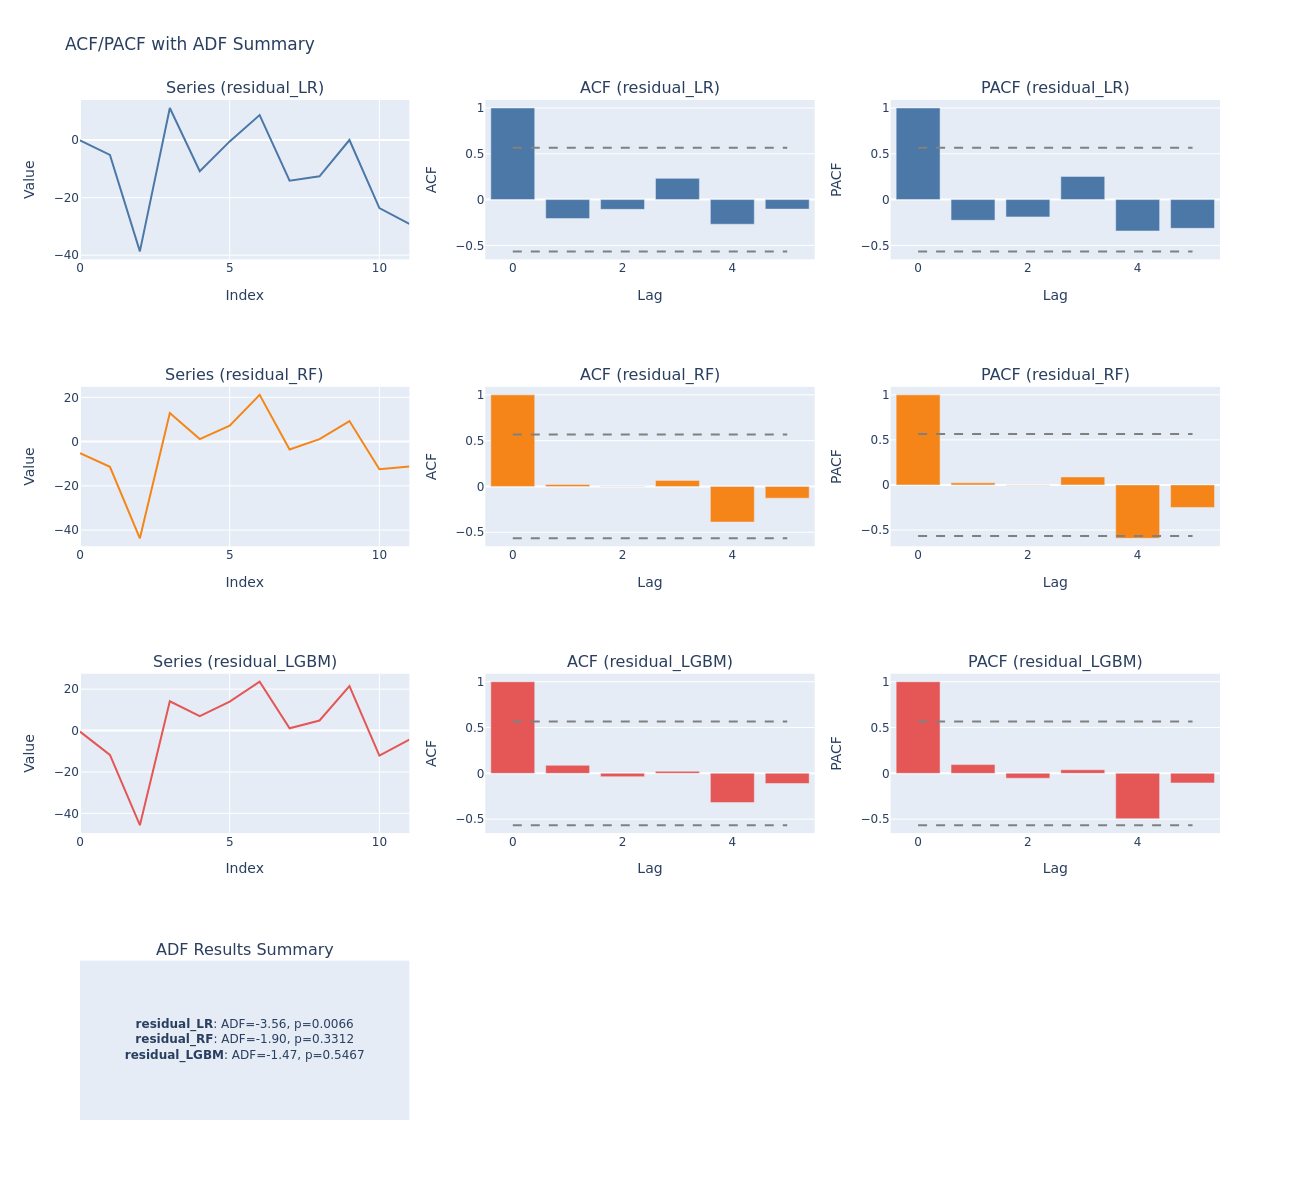

In [231]:
stationarity_check(test[["residual_LR", "residual_RF", "residual_LGBM"]], nlags=30, fig_type="png")

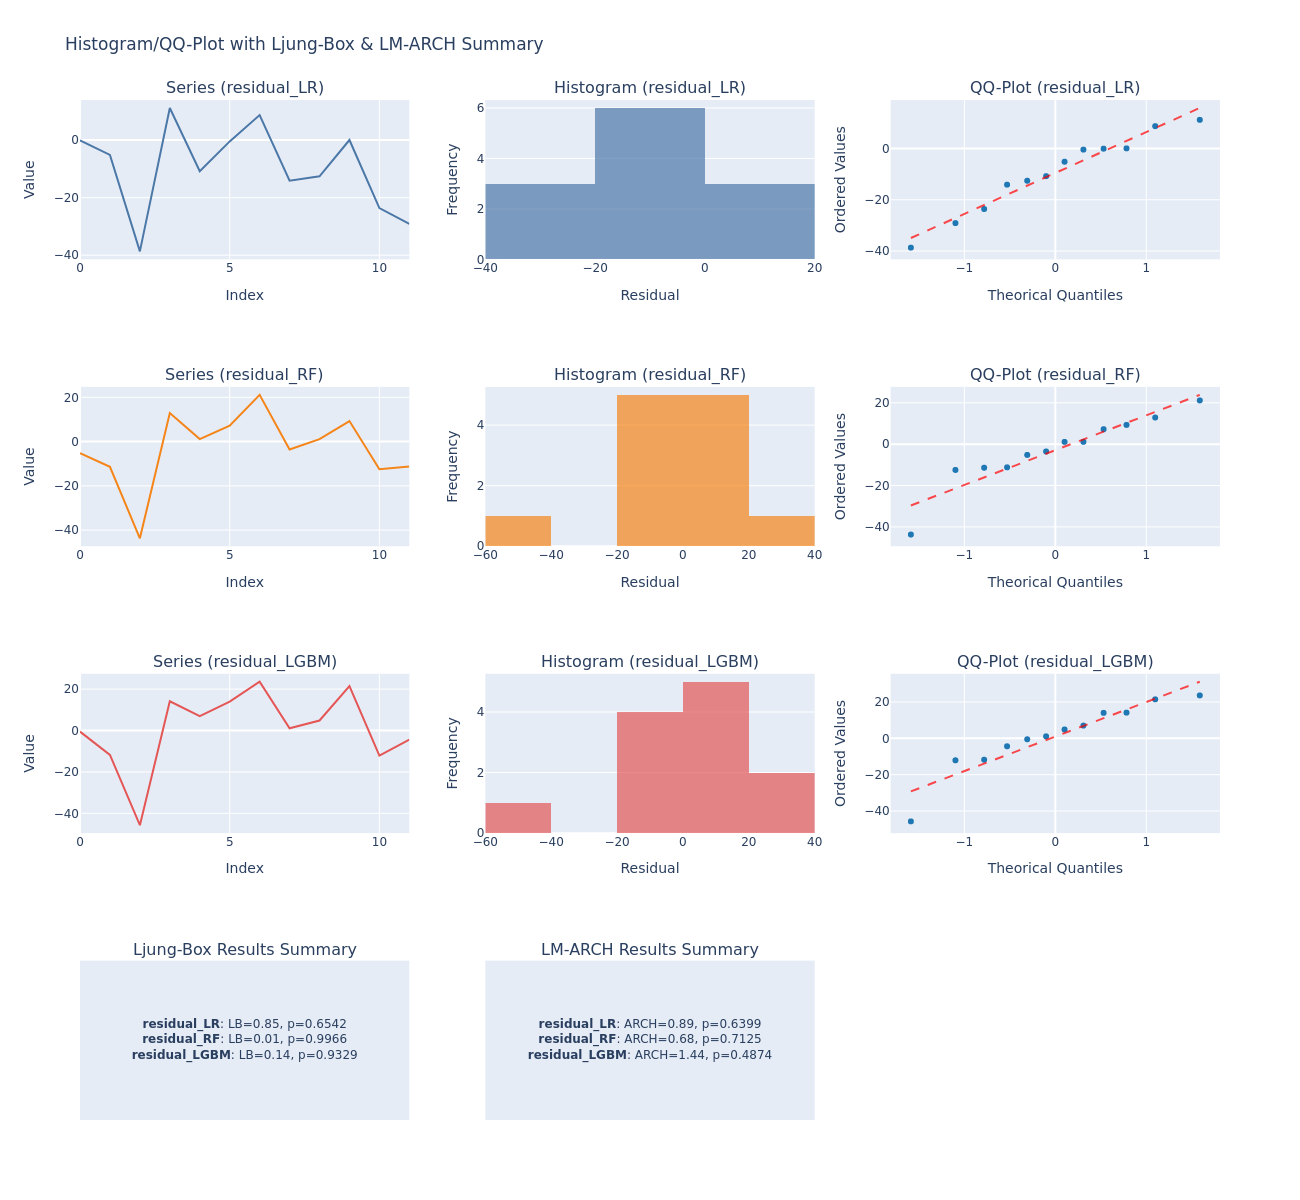

In [232]:
residual_check(test[["residual_LR", "residual_RF", "residual_LGBM"]], nlags=12, fig_type="png")

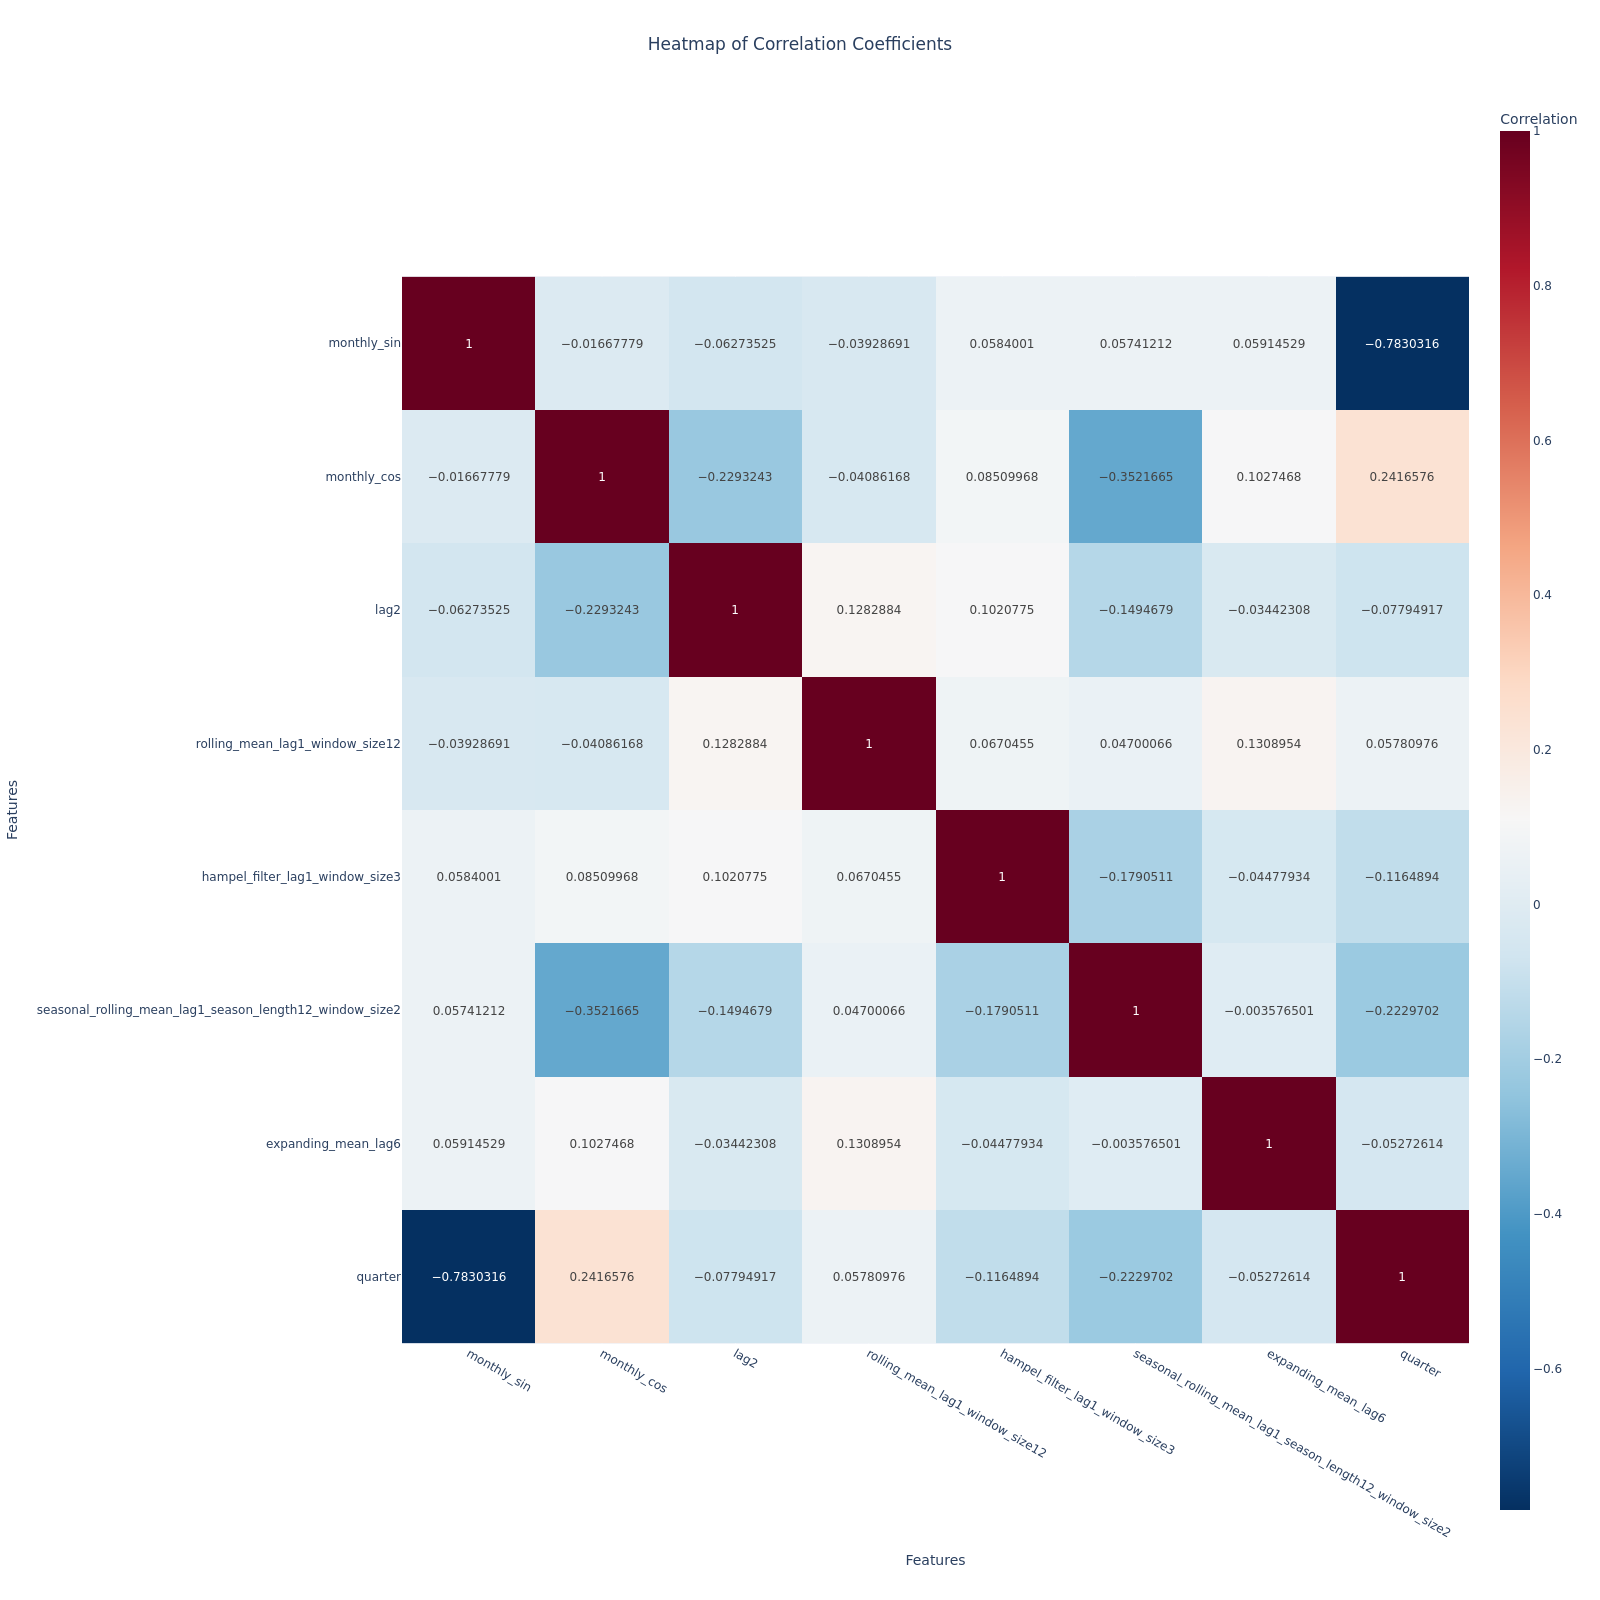

In [227]:
corr_heatmap(mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]), fig_type="png")

In [228]:
filter_features_by_vif(
    mf.preprocess(train, static_features=[]).drop(columns=["unique_id", "ds", "y"]),
    threshold=5.0,
    verbose=True,
)

array([ True,  True,  True,  True,  True,  True,  True,  True])